In [17]:
# 1. Install and Import Libraries
# We install Stanza for high-quality Latvian lemmatization.
!pip install stanza -q

import os
import re
import zipfile
import io
import pandas as pd
import numpy as np
import stanza
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# 2. Initialize Stanza for Latvian
# This downloads the linguistic models (approx. 300MB)
print("Downloading Latvian language model...")
stanza.download('lv', processors='tokenize,pos,lemma')

# Initialize the pipeline.
# use_gpu=True significantly speeds up processing if Colab GPU is enabled.
nlp = stanza.Pipeline('lv', processors='tokenize,pos,lemma', use_gpu=True, logging_level='WARN')

# 3. Upload and Extract Data
print("\n--- UPLOAD ZIP FILE ---")
print("Please upload a .zip archive containing your Latvian .txt files.")
uploaded = files.upload()

if not uploaded:
    raise SystemExit("No file uploaded.")

zip_name = next(iter(uploaded.keys()))
extract_dir = "leaflets_zip"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as zf:
    zf.extractall(extract_dir)

# Gather all .txt files
text_files = [os.path.join(extract_dir, f) for f in os.listdir(extract_dir) if f.lower().endswith('.txt')]
print(f"Successfully extracted {len(text_files)} text files.")


--- UPLOAD ZIP FILE ---
Please upload a .zip archive containing your Latvian .txt files.


Saving latvian_communist_leaflets_1934-1940_only_unique.zip to latvian_communist_leaflets_1934-1940_only_unique (1).zip
Successfully extracted 251 text files.


In [18]:
# --- Configuration for Cleaning ---

# Define Latvian stop words (Lemmatized forms).
# We include common verbs like 'būt' (to be) and 'tikt' (to become).
LATVIAN_STOP_LEMMAS = set('''
    un ir būt tikt kļūt par lai kas bet arī kā tas šis
    pie pret vai kad tad tik ar no uz mēs jūs viņš viņa
    kurš kāds viss jo gan vēl jau pat kurp ne nav
    ļoti tikai nekā taču man tevi sev savs
'''.split())

# Metadata keywords to remove
META_STOP = {"id", "file_name", "title", "author", "date", "source", "text"}
STOPWORDS = LATVIAN_STOP_LEMMAS | META_STOP

# Allowed Parts of Speech (UPOS tags)
# We only keep Nouns, Verbs, Adjectives, and Proper Nouns for topic modeling.
ALLOWED_POS = {'NOUN', 'VERB', 'ADJ', 'PROPN'}

def lemmatize_text(full_text: str) -> str:
    # 1) Cut everything before 'text:' (case-insensitive)
    parts = re.split(r'(?im)^\s*text\s*:\s*', full_text, maxsplit=1)
    text = parts[1] if len(parts) == 2 else full_text  # fallback: если нет text:

    # Safety: truncate extremely long files
    if len(text) > 100000:
        text = text[:100000]

    doc = nlp(text)

    lemmas = []
    for sent in doc.sentences:
        for word in sent.words:
            lemma = (word.lemma or "").lower()
            if len(lemma) > 2 and lemma not in STOPWORDS and word.upos in ALLOWED_POS:
                lemmas.append(lemma)

    return " ".join(lemmas)

# --- Execution Loop ---
data_rows = []
print(f"Starting lemmatization of {len(text_files)} files...")

for i, filepath in enumerate(text_files):
    try:
        with open(filepath, 'r', encoding='utf-8', errors='replace') as f:
            raw_content = f.read()

        # Apply the lemmatization function
        clean_content = lemmatize_text(raw_content)

        # Try to extract a year from the filename (e.g., 'doc_1934.txt')
        year_match = re.search(r'19(3[0-9]|4[0-9])', os.path.basename(filepath))
        year = int(year_match.group(0)) if year_match else None

        data_rows.append({
            "file_name": os.path.basename(filepath),
            "year": year,
            "raw_text": raw_content,
            "clean_text": clean_content
        })

        # Print progress every 10 files
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(text_files)} files...")

    except Exception as e:
        print(f"Error processing {filepath}: {e}")

# Create DataFrame
df = pd.DataFrame(data_rows)
print("Preprocessing complete.")
display(df.head(3))

Starting lemmatization of 251 files...
Processed 10/251 files...
Processed 20/251 files...
Processed 30/251 files...
Processed 40/251 files...
Processed 50/251 files...
Processed 60/251 files...
Processed 70/251 files...
Processed 80/251 files...
Processed 90/251 files...
Processed 100/251 files...
Processed 110/251 files...
Processed 120/251 files...
Processed 130/251 files...
Processed 140/251 files...
Processed 150/251 files...
Processed 160/251 files...
Processed 170/251 files...
Processed 180/251 files...
Processed 190/251 files...
Processed 200/251 files...
Processed 210/251 files...
Processed 220/251 files...
Processed 230/251 files...
Processed 240/251 files...
Processed 250/251 files...
Preprocessing complete.


,file_name,year,raw_text,clean_text
0,revl-n058-LKJS_CK-3000-1934-08-16.txt,1934,id: 58\nfile_name: revl-n058-LKJS_CK-1934-08-1...,cīņa uzvara zeme proletārietis savienoties lat...
1,revl-n017-LKP_CK_Womens_center-5000-[…1934-03-...,1934,id: 17\nfile_name: revl-n017-LKP_CK_Womens_cen...,cīņa uzvara zeme proletārietis savienoties dar...
2,revl-n081-LKP_CK-10000-[1934-11-02…].txt,1934,id: 81\nfile_name: revl-n081-LKP_CK-10000-[193...,cīņa uzvara zeme proletārietis savienoties faš...


In [19]:
# --- 1. Vectorization (TF-IDF) ---
# We use the 'clean_text' column which contains the lemmas.
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,            # Ignore words appearing in less than 2 docs
    max_df=0.95          # Ignore words appearing in > 95% of docs (too common)
)

X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"TF-IDF Matrix Shape: {X_tfidf.shape} (Documents, Unique Lemmas)")

# --- 2. Topic Modeling (NMF) ---
N_TOPICS = 6  # Number of topics to find (Adjust this as needed)

nmf_model = NMF(
    n_components=N_TOPICS,
    random_state=42,
    init='nndsvda',
    max_iter=1000
)

# W matrix: Document-Topic weights
W = nmf_model.fit_transform(X_tfidf)
# H matrix: Topic-Term weights
H = nmf_model.components_

# --- 3. Display Topics ---
print(f"\nTop words per topic (N={N_TOPICS}):")
topic_summaries = []

for topic_idx, topic in enumerate(H):
    # Get indices of top 15 words for this topic
    top_indices = topic.argsort()[::-1][:15]
    top_words = [tfidf_feature_names[i] for i in top_indices]

    summary = ", ".join(top_words)
    topic_summaries.append(summary)
    print(f"Topic {topic_idx}: {summary}")

# --- 4. Assign Topics to DataFrame ---
# Find the topic with the highest weight for each document
df['topic_id'] = W.argmax(axis=1)
df['topic_score'] = W.max(axis=1)
df['topic_keywords'] = df['topic_id'].apply(lambda x: topic_summaries[x])

display(df[['file_name', 'year', 'topic_id', 'topic_keywords']].head())

TF-IDF Matrix Shape: (251, 14679) (Documents, Unique Lemmas)

Top words per topic (N=6):
Topic 0: tauta, latvija, spānija, brīvība, ulmanis, valdība, latvis, sprs, vācija, demokrātisks, latvis tauta, hitlers, miers, valsts, vāci
Topic 1: strādnieks, darbs, alga, arodbiedrība, valdība, fašistisks, cīņa, uzņēmējs, streiks, bezdarbnieks, stāvoklis, prasība, darbs alga, biedrs, prasīt
Topic 2: jaunatne, skola, darbs, jaunietis, darbs jaunatne, skolnieks, cīņa, latvija, izglītība, lauks, revolucionārs, darbs jaunietis, organizācija, strādnieks, jaunatne organizācija
Topic 3: sieviete, darbs sieviete, darbs, bērns, māte, ģimene, vīrietis, diena, sieviete cmāte, māte diena, cmāte, vienāds, madīt, marts, buržujs madīt
Topic 4: sarkans palīdzība, ieslodzīt, cietums, palīdzība, latvija, sarkans, darbs tauta, darbs, nāve, fašists, tauta, protests, spīdzināšana, strādnieks, politieslodzīt
Topic 5: karš, sprs, buržuāzija, padomju, latvija, pasaule, strādnieks, valsts, cīņa, armija, vācija, darbaļau

,file_name,year,topic_id,topic_keywords
0,revl-n058-LKJS_CK-3000-1934-08-16.txt,1934,2,"jaunatne, skola, darbs, jaunietis, darbs jauna..."
1,revl-n017-LKP_CK_Womens_center-5000-[…1934-03-...,1934,3,"sieviete, darbs sieviete, darbs, bērns, māte, ..."
2,revl-n081-LKP_CK-10000-[1934-11-02…].txt,1934,1,"strādnieks, darbs, alga, arodbiedrība, valdība..."
3,revl-n167-LKP_Riga_committee-4000-[…1936-02-14...,1936,1,"strādnieks, darbs, alga, arodbiedrība, valdība..."
4,revl-n237-LKP_CK_LSSZP_CK_LDJS_CK-5000-[1939-1...,1939,0,"tauta, latvija, spānija, brīvība, ulmanis, val..."


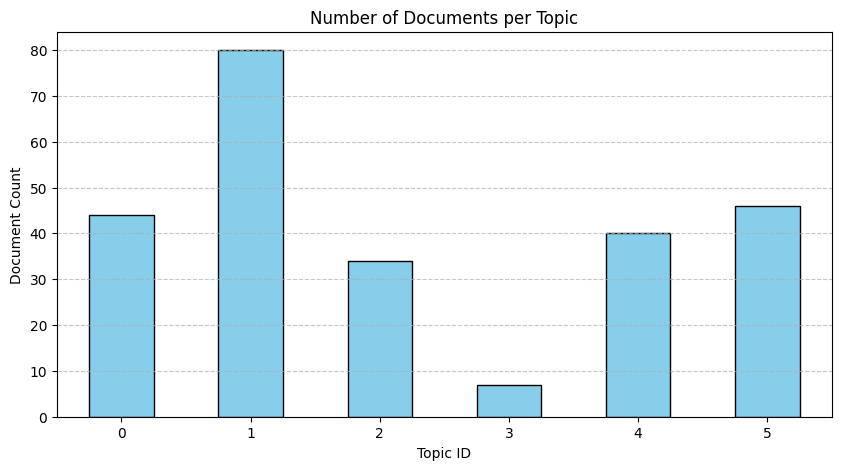

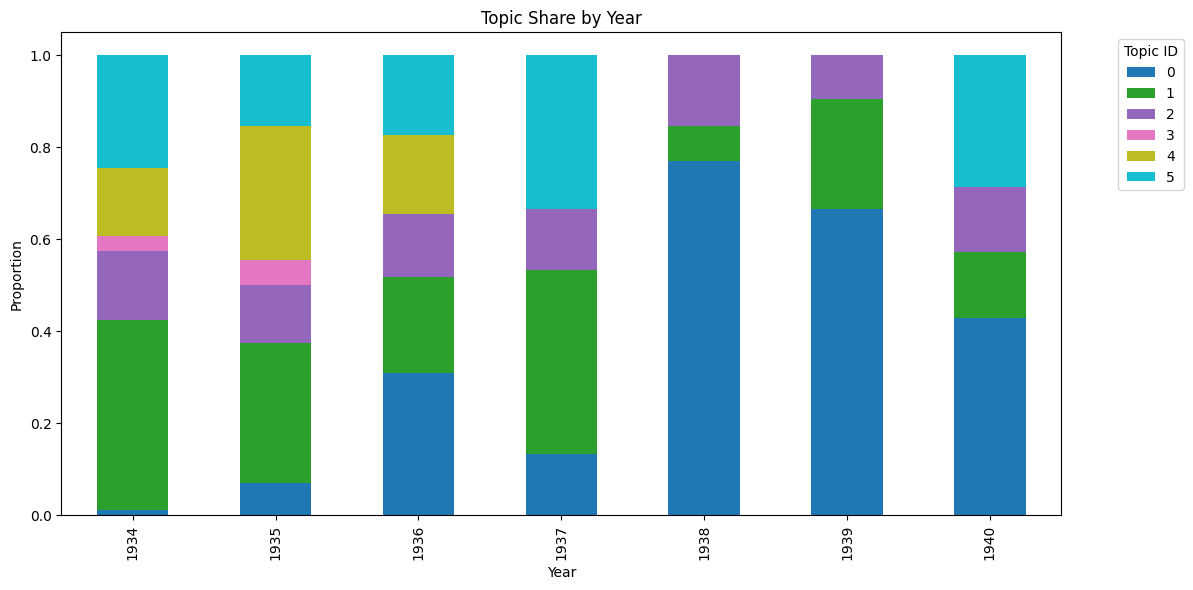

In [20]:
# --- 1. Topic Distribution Bar Chart ---
plt.figure(figsize=(10, 5))
topic_counts = df['topic_id'].value_counts().sort_index()
topic_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Documents per Topic')
plt.xlabel('Topic ID')
plt.ylabel('Document Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 2. Topic Evolution Over Time (Stacked Bar) ---
# Only run this if we successfully extracted years
if df['year'].notna().sum() > 5:
    # Create a pivot table: Year vs Topic Count
    pivot_df = df.groupby(['year', 'topic_id']).size().unstack(fill_value=0)

    # Normalize to get percentages (share of topics per year)
    pivot_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0)

    # Plot
    pivot_pct.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10')
    plt.title('Topic Share by Year')
    plt.ylabel('Proportion')
    plt.xlabel('Year')
    plt.legend(title='Topic ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough year data detected in filenames for time-series plotting.")

In [21]:
output_filename = 'latvian_topics_lemmatized.csv'
df.to_csv(output_filename, index=False)

print(f"Saved results to {output_filename}")
files.download(output_filename)

Saved results to latvian_topics_lemmatized.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Calculations started. Please wait...
Checked N=2, Error=14.84
Checked N=3, Error=14.71
Checked N=4, Error=14.58
Checked N=5, Error=14.47
Checked N=6, Error=14.38
Checked N=7, Error=14.29
Checked N=8, Error=14.22
Checked N=9, Error=14.14
Checked N=10, Error=14.07
Checked N=11, Error=14.00
Checked N=12, Error=13.93
Checked N=13, Error=13.88
Checked N=14, Error=13.82
Checked N=15, Error=13.76


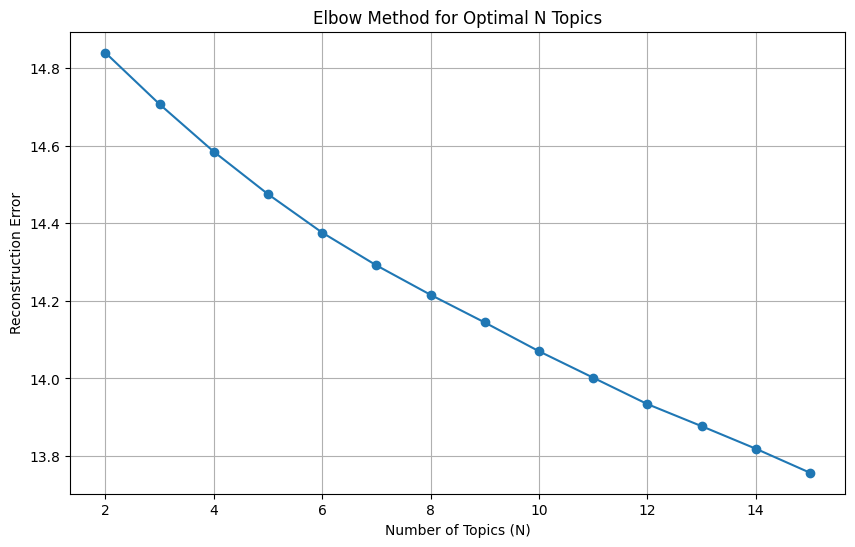

In [22]:
#ELBOW OPTIMAL

import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

n_range = range(2, 16)
reconstruction_errors = []

print("Calculations started. Please wait...")

for n in n_range:
    nmf_test = NMF(n_components=n, init='nndsvda', random_state=42, max_iter=500)
    nmf_test.fit(X_tfidf)
    reconstruction_errors.append(nmf_test.reconstruction_err_)
    print(f"Checked N={n}, Error={nmf_test.reconstruction_err_:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(n_range, reconstruction_errors, marker='o')
plt.title('Elbow Method for Optimal N Topics')
plt.xlabel('Number of Topics (N)')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

In [23]:
def check_lemmatization_quality(search_query):
    """
    Searches for a file in the DataFrame and displays the difference
    between the raw text and the lemmatized output.

    Args:
        search_query (str): Part of the filename to search for (e.g., '1934' or 'work_1')
    """
    # Filter the DataFrame for filenames containing the query
    # Ensure column names match your DataFrame ('file_name', 'raw_text', 'clean_text')
    found_row = df[df['file_name'].astype(str).str.contains(search_query, case=False)]

    if found_row.empty:
        print(f"❌ No file found containing the string: '{search_query}'")
        return

    # Select the first matching document
    row = found_row.iloc[0]
    filename = row['file_name']

    # Handle potential column name variations just in case
    raw_content = row['raw_text'] if 'raw_text' in row else row.get('raw', '')
    clean_content = row['clean_text'] if 'clean_text' in row else row.get('clean', '')

    print(f"📄 PROOF CHECK: {filename}")
    print("="*60)

    # 1. Show a snippet of the original text
    print("\n🔻 [ORIGINAL RAW TEXT]:")
    # Show first 300 chars, remove newlines for readability
    print(raw_content[:300].replace('\n', ' ') + "...")

    # 2. Show a snippet of the processed text
    print("\n✅ [LEMMATIZED OUTPUT]:")
    print(clean_content[:300] + "...")

    print("\n" + "="*60)

    # 3. Analyze specific tokens
    print("🔍 Token Inspection (First 10 lemmas):")
    clean_words = clean_content.split()
    print(f"List: {clean_words[:10]}")

    print("\n--- HOW TO INTERPRET ---")
    print("1. Are endings removed? (e.g., 'Latvijas' -> 'latvija', 'darbiem' -> 'darbs')")
    print("2. Are stopwords gone? (Words like 'un', 'ir', 'ka' should be missing)")
    print("3. If YES, the model is working correctly.")

# --- RUN THE CHECK ---
# Replace "1" with any part of a filename you want to inspect (e.g., "1934")
check_lemmatization_quality("1")

📄 PROOF CHECK: revl-n058-LKJS_CK-3000-1934-08-16.txt

🔻 [ORIGINAL RAW TEXT]:
id: 58 file_name: revl-n058-LKJS_CK-1934-08-16.txt title: LKJS CK lapiņa, kas veltīta Starptautiskajai jaunatnes dienai, ar aicinājumu sakļauties LKP un LKJS vadībā vienotā pretfašisma cīņas frontē pret imperiālistiska kara gatavošanu un intervences draudiem pret PSRS author: LKJS CK date: 1934-08-1...

✅ [LEMMATIZED OUTPUT]:
cīņa uzvara zeme proletārietis savienoties latvija jauns strādeieks skolnieks studenss apspiesta latvija jaunatne gads revolucionārs jaunatne pasaule atzīmēt starptautisks jaunatne diena izsacīt protests gatavot jauns slaktiņš asiņains fašisms kapitālistisks izsūkšana demonstrēt simpātija padomju sa...

🔍 Token Inspection (First 10 lemmas):
List: ['cīņa', 'uzvara', 'zeme', 'proletārietis', 'savienoties', 'latvija', 'jauns', 'strādeieks', 'skolnieks', 'studenss']

--- HOW TO INTERPRET ---
1. Are endings removed? (e.g., 'Latvijas' -> 'latvija', 'darbiem' -> 'darbs')
2. Are stopwords gone? (

In [24]:
test_phrase = "Kārļa Ulmaņa fašistiskā valdība, kas bendē tautu, atkal palielina nodokļus!"
processed = lemmatize_text(test_phrase)

print(f"Phrase: {test_phrase}")
print(f"Lemma: {processed}")


Phrase: Kārļa Ulmaņa fašistiskā valdība, kas bendē tautu, atkal palielina nodokļus!
Lemma: kārlis ulmanis fašistisks valdība bendēt tauta palielināt nodoklis
